# De spectrometer

## Import packages

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.optimize as opt

sp.init_printing()

In [2]:
# interactieve plots in jupyter lab - niet runnen als je de extensie niet hebt!
#%matplotlib widget
mpl.rcParams['figure.dpi'] = 150
extensie = 'pdf'

## hulpfuncties

In [3]:
def DMS_to_rad(dd, mm, ss=0):
    degrees = dd + mm/60 + ss/3600
    return np.radians(degrees)

def error(function, variables, deviations):
    return sp.sqrt(sum([sp.diff(function, variables[i])**2 * deviations[i]**2 for i in range(len(variables))]))


## Analoge spectrometer

### Voorbereidende opgaves

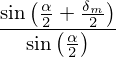

In [4]:
# variabelen voor functie
lam, delta, alfa = sp.symbols('lambda, delta_m, alpha')
# standaardafwijkingen op deze variabelen
dlam, ddelta, dalfa = sp.symbols('S_lambda, S_delta, S_alpha')
# functie die brekingsindex geeft in functie dispersie en opening
n = sp.sin((delta + alfa)/2)/sp.sin(alfa/2)
display(n)

In [5]:
# gegeven waardes voor de hoeken
ALFA = DMS_to_rad(60, 18, 0)
S_ALFA = DMS_to_rad(0, 10, 0)/np.sqrt(3)
DELTA = DMS_to_rad(35, 46, 0)
S_DELTA = DMS_to_rad(0, 20, 0)/np.sqrt(3)
# bereken de waarde van n:
N = n.subs({alfa : ALFA, delta : DELTA})
display(N)
# bereken de fout op N
dn = error(n, [alfa, delta], [dalfa, ddelta])
DN = dn.subs({alfa : ALFA, delta : DELTA, dalfa : S_ALFA, ddelta : S_DELTA})
display(DN)

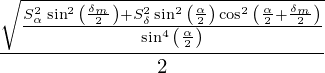

In [6]:
display(sp.simplify(dn))

### Heliumbron

**Data bron**

In [7]:
nulhoek = np.array([-1, -27])
lijn1 = np.array([[46, 0]]) - nulhoek
lijn2 = np.array([[46, 16], [46, 9], [46, 9]]) - nulhoek
lijn3 = np.array([[46, 40], [46, 34], [46, 34]]) - nulhoek
lijn4 = np.array([[47, 45]]) - nulhoek
lijn5 = np.array([[47, 46], [47, 47], [47, 45]]) - nulhoek
lijn6 = np.array([[47, 54]]) - nulhoek
lijn7 = np.array([[48, 17], [48, 16], [48, 16]]) - nulhoek
lijn8 = np.array([[48, 41], [48, 44], [48, 43]]) - nulhoek

In [8]:
lijnen = [lijn1, lijn2, lijn3, lijn4, lijn5, lijn6, lijn7, lijn8]
rad = [DMS_to_rad(lijn[:,0], lijn[:,1]) for lijn in lijnen]
mean = np.array([radialen.mean() for radialen in rad])
stdv = np.array([radialen.std() for radialen in rad])
# golflengtes gegeven
LAMBDA = np.array([706.5, 667.8, 587.5, 504.8, 501.6, 492.1, 471.3, 447.1])

In [9]:
colors = ["#f10000", "#ff0000", "#ffdf00", "#00ff3f", "#00ff66", "#00ffe5", "#009eff", "#0023ff"]

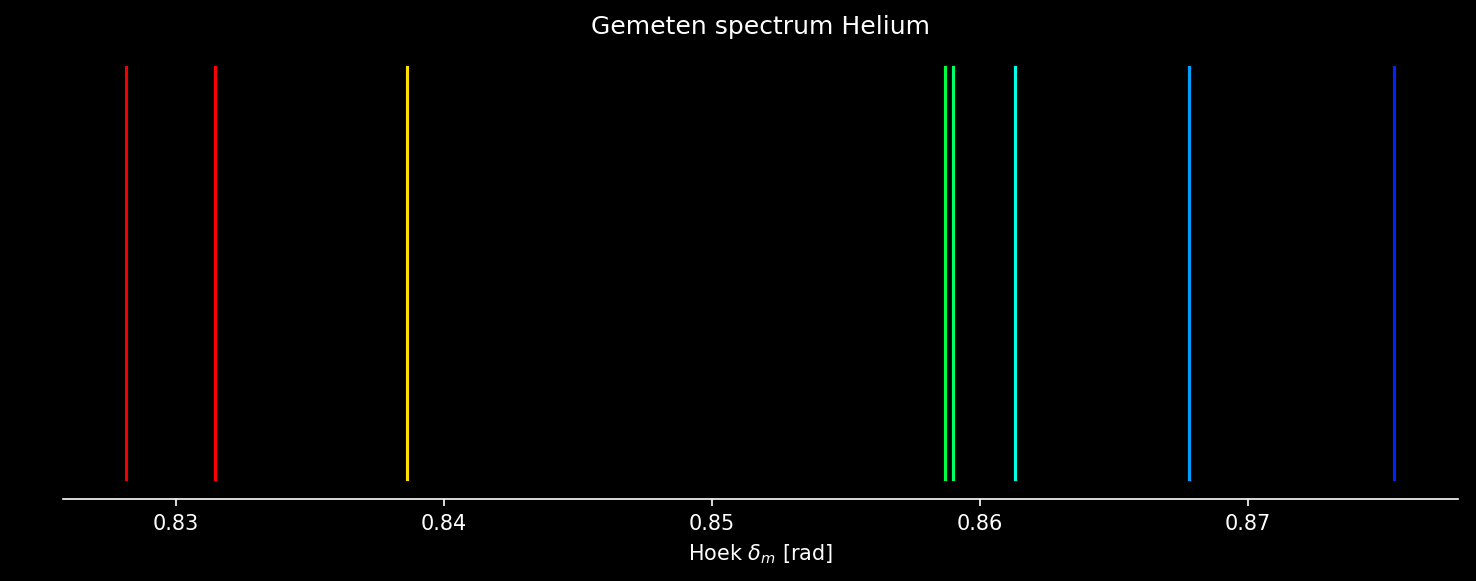

In [10]:
# plot van het gemeten spectrum
fig, ax = plt.subplots(1,1,figsize=(12,4))

for i in range(8):
    angle = mean[i]
    ax.plot([angle, angle], [0, 1], color=colors[i])

ax.set_facecolor("k")
fig.set_facecolor("k")
ax.tick_params(axis='x', color='w', labelcolor='w')
ax.spines['bottom'].set_color('w')
ax.set_xlabel('Hoek $\delta_m$ [rad]')
ax.xaxis.label.set_color('w')
plt.title('Gemeten spectrum Helium', color='w')
plt.show()

fig.savefig("plots/spectrum Helium.%s" %extensie, facecolor='k', dpi=300)

In [11]:
# openingshoek prisma
ALPHA = DMS_to_rad(60, 0)
# bereken de n-waardes
n_num = sp.lambdify([delta, alfa], n, "numpy")(mean, ALPHA*np.ones_like(mean))

**Bereken de fouten op de gemeten hoeken**

In [12]:
sys_fout = DMS_to_rad(0, 3)/np.sqrt(3)*np.sqrt(2)
errors = np.array([max(sys_fout/np.sqrt(len(lijnen[i])), stdv[i]) for i in range(8)])
# bereken de fouten op n
S_n = sp.lambdify([alfa, delta, dalfa, ddelta], dn, "numpy")(ALPHA*np.ones_like(mean), mean, errors, np.zeros_like(mean))

**Fit de rechte door de data**

In [13]:
# de te fitten functie
def Cauchy(lam, B, C):
    return C + B/lam**2

In [14]:
# vind de fitparameters
fit = opt.curve_fit(Cauchy, LAMBDA, n_num, (0, 100))

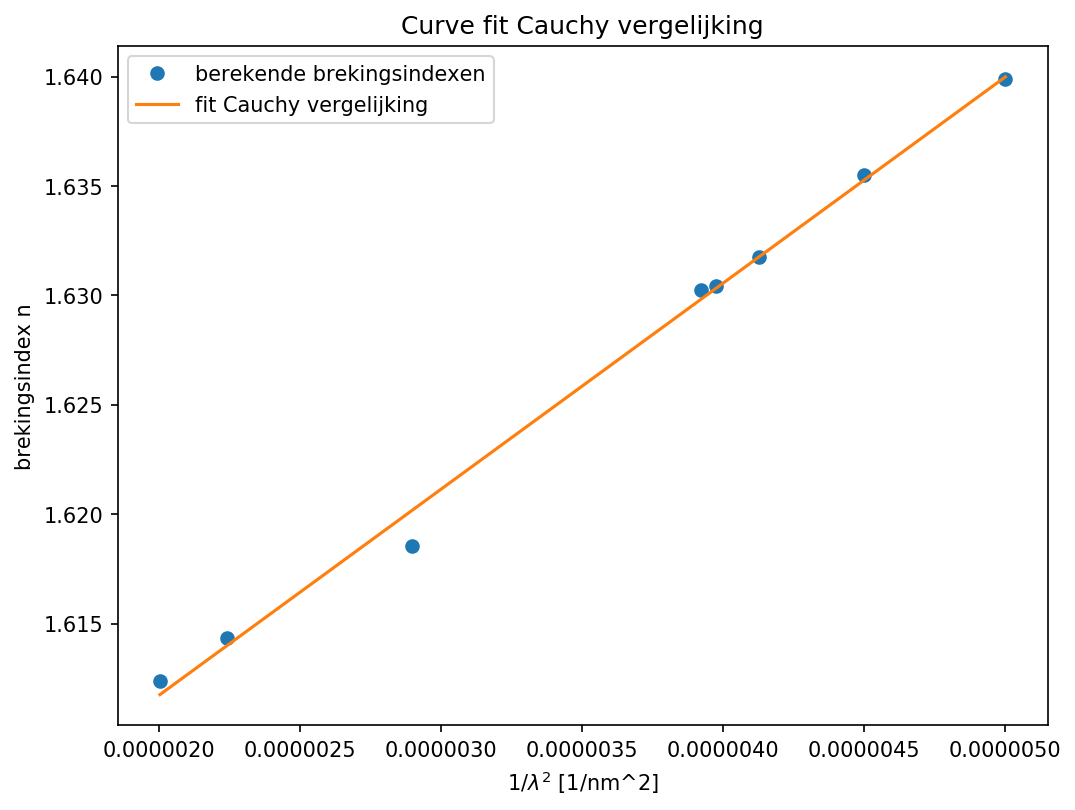

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

X = np.linspace(LAMBDA.min(), LAMBDA.max(), 1000)
ax.plot(1/LAMBDA**2, n_num, 'o', label="berekende brekingsindexen")
ax.plot(1/X**2, Cauchy(X, *fit[0]), label="fit Cauchy vergelijking")
ax.set_ylabel("brekingsindex n")
ax.set_xlabel("$1/\lambda^2$ [1/nm^2]")

plt.title("Curve fit Cauchy vergelijking")
plt.legend()

plt.show()

fig.savefig("plots/Fit Cauchyvergelijking.%s" %extensie, dpi=300)

**Print de fitparameters**

In [16]:
print("B: %.0f +- %.0f \n C: %.4f +- %.4f" %(fit[0][0], np.sqrt(fit[1][0,0]), fit[0][1], np.sqrt(fit[1][1,1])))

B: 9416 +- 262 
 C: 1.5929 +- 0.0010


### Onbekende bron

**Data bron**

In [17]:
lijn1 = np.array([[46, 51], [46, 51], [46, 49], [46, 49]]) - nulhoek
lijn2 = np.array([[47, 12], [47, 7], [47, 11], [47, 9]]) - nulhoek
lijn3 = np.array([[48, 57], [48, 58], [48, 59], [48, 59]]) - nulhoek

In [18]:
lijnen = [lijn1, lijn2, lijn3]
rad = [DMS_to_rad(lijn[:,0], lijn[:,1]) for lijn in lijnen]
mean = np.array([radialen.mean() for radialen in rad])
stdv = np.array([radialen.std() for radialen in rad])

**Omrekenen graden naar golflengtes**

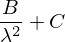

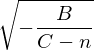

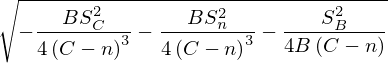

In [19]:
# definieer de Cauchy vergelijking als sympy functie
B, C, n_sym, S_B, S_C, S_n_sym = sp.symbols('B, C, n, S_B, S_C, S_n')
cauchy = B/lam**2 + C
display(cauchy)
# inverteer cauchy naar golflengte = ...
cauchy_inv = sp.solve(sp.Eq(cauchy, n_sym), lam)[1]
display(cauchy_inv)
# bereken de foutenpropagatieformule op cauchy_inv
sym = [B, C, n_sym]
S_sym = [S_B, S_C, S_n_sym]
S_lam = error(cauchy_inv, sym, S_sym)
display(S_lam)

In [20]:
# bereken n uit de gemeten hoeken en de fout op n
n_num = sp.lambdify([delta, alfa], n, "numpy")(mean, ALPHA*np.ones_like(mean))
# bereken de fout op elke hoek, rekening houdend met de systematische fout
sys_fout = DMS_to_rad(0, 3)/np.sqrt(3)*np.sqrt(2)
errors = np.array([max(sys_fout/np.sqrt(len(lijnen[i])), stdv[i]) for i in range(3)])
# bereken de fouten op n
S_n = sp.lambdify([alfa, delta, dalfa, ddelta], dn, "numpy")(ALPHA*np.ones_like(mean), mean, errors, np.zeros_like(mean))

In [21]:
# bereken uit de brekingsindexen  de golflengtes
B_num, C_num = (fit[0][0], fit[0][1])
S_B_num, S_C_num = np.sqrt(np.array([fit[1][0,0], fit[1][1,1]]))
LAMBDA = sp.lambdify(sym, cauchy_inv, "numpy")(B_num*np.ones_like(n_num), C_num*np.ones_like(n_num), n_num)
S_LAMBDA = sp.lambdify(sym + S_sym, S_lam, "numpy")(B_num*np.ones_like(n_num), C_num*np.ones_like(n_num), n_num, S_B_num*np.ones_like(n_num), S_C_num*np.ones_like(n_num), S_n)

In [22]:
display(LAMBDA, np.sqrt(S_LAMBDA))

array([579.41978399, 547.56104395, 435.63239118])

array([3.63861683, 3.47717932, 2.74454392])

**Importeer spectrum van kwik**

In [23]:
spectrum = pd.read_csv("mercury.txt", sep="   ", names=["wavelength", "intensity"])
spectrum = spectrum.loc[spectrum['intensity'] >= 1100]
spectrum["wavelength"] = spectrum["wavelength"]/10
spectrum

/home/pieter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,wavelength,intensity
0,404.656,1800
5,435.833,2000
22,546.074,1100
25,576.960,1240
26,578.966,1100


In [24]:
# selecteer enkel de lijnen die ik ook zag
spectrum = spectrum.loc[[5, 22, 26]]
spectrum

,wavelength,intensity
5,435.833,2000
22,546.074,1100
26,578.966,1100


**Maak een plot van het gemeten spectrum van kwik**

In [25]:
colors=["#fcff00", "#9cff00", "#1d00ff"]
width = [4, 1.5, 1.5]

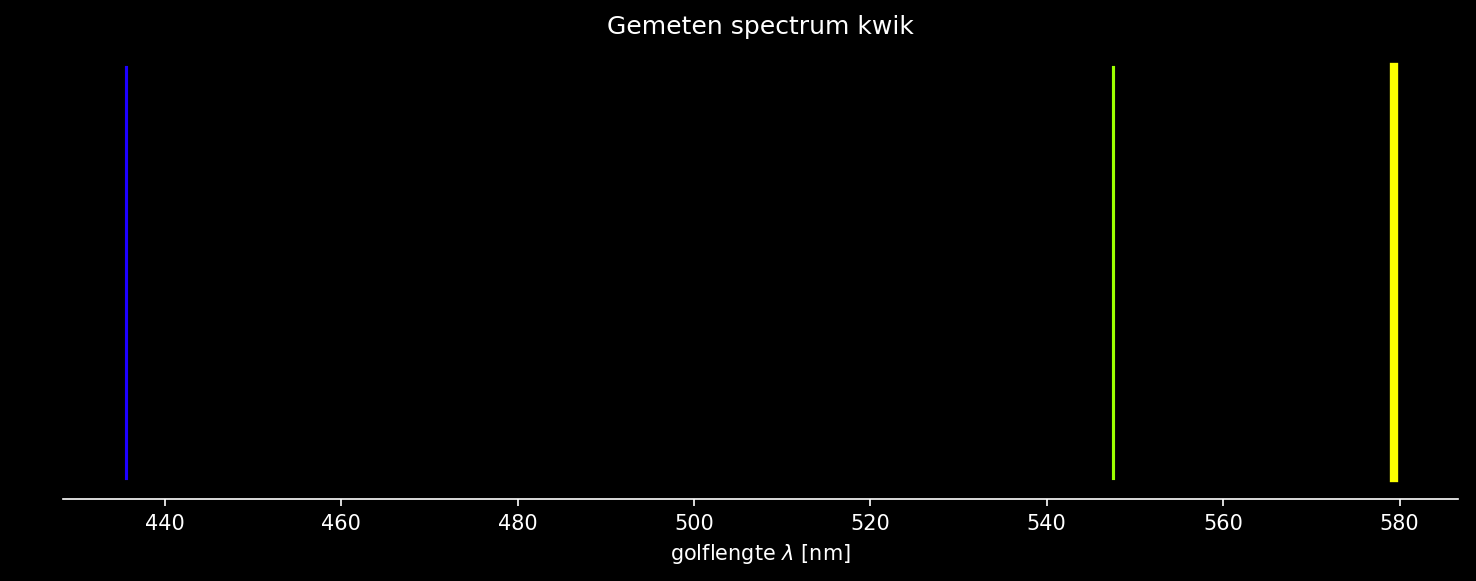

In [26]:
# plot van het gemeten spectrum
fig, ax = plt.subplots(1,1,figsize=(12,4))

for i in range(3):
    length = LAMBDA[i]
    ax.plot([length, length], [0, 1], color=colors[i], linewidth=width[i])
    length = spectrum["wavelength"].values[2-i]
    #ax.plot([length, length], [1, 2], color=colors[i], linewidth=width[i])

ax.set_facecolor("k")
fig.set_facecolor("k")
ax.tick_params(axis='x', color='w', labelcolor='w')
ax.spines['bottom'].set_color('w')
ax.set_xlabel('golflengte $\lambda$ [nm]')
ax.xaxis.label.set_color('w')
plt.title('Gemeten spectrum kwik', color='w')
plt.show()

fig.savefig("plots/spectrum kwik.%s" %extensie, facecolor='k', dpi=300)

## Emissiespectra

### Importeren data emissiespectra

In [27]:
folder = 'digitale spectra/'
# importeren spectra helium
helium = [pd.read_csv('%shelium_%d.txt' %(folder, i), skiprows=17, decimal=',', sep='\t', 
                       index_col='wavelength', names=['wavelength', 'intensity']) for i in range(1,4)]
kwik = [pd.read_csv('%skwik_%d.txt' %(folder, i), skiprows=17, decimal=',', sep='\t', 
                       index_col='wavelength', names=['wavelength', 'intensity']) for i in range(1,6)]
TL = [pd.read_csv('%sTL_%d.txt' %(folder, i), skiprows=17, decimal=',', sep='\t', 
                       index_col='wavelength', names=['wavelength', 'intensity']) for i in range(1,9)]

### plot de spectra om de beste eruit te kiezen

Spectra Helium:

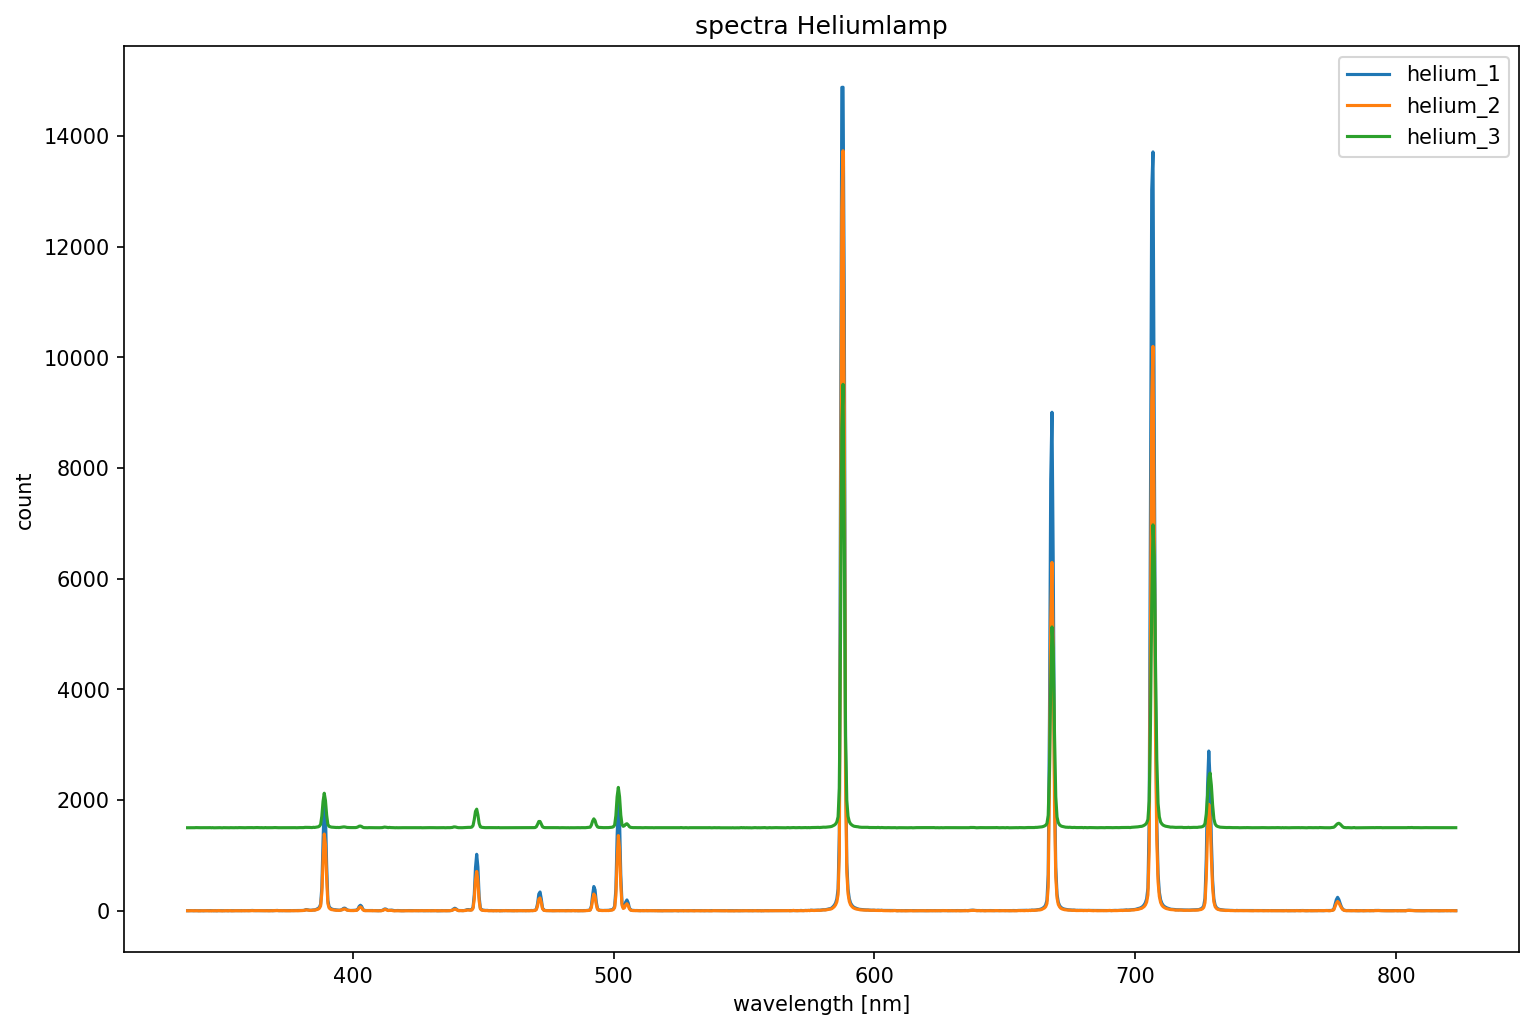

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for i in range(3):
    spectrum = helium[i]
    ax.plot(spectrum.index, spectrum['intensity'], label="helium_%d" %(i+1))
    
plt.title('spectra Heliumlamp')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('count')
plt.legend()
    
plt.show()

Helium_1 heef de beste data, we werken hiermee verder

In [29]:
spec_He = helium[0]

Spectra kwiklamp

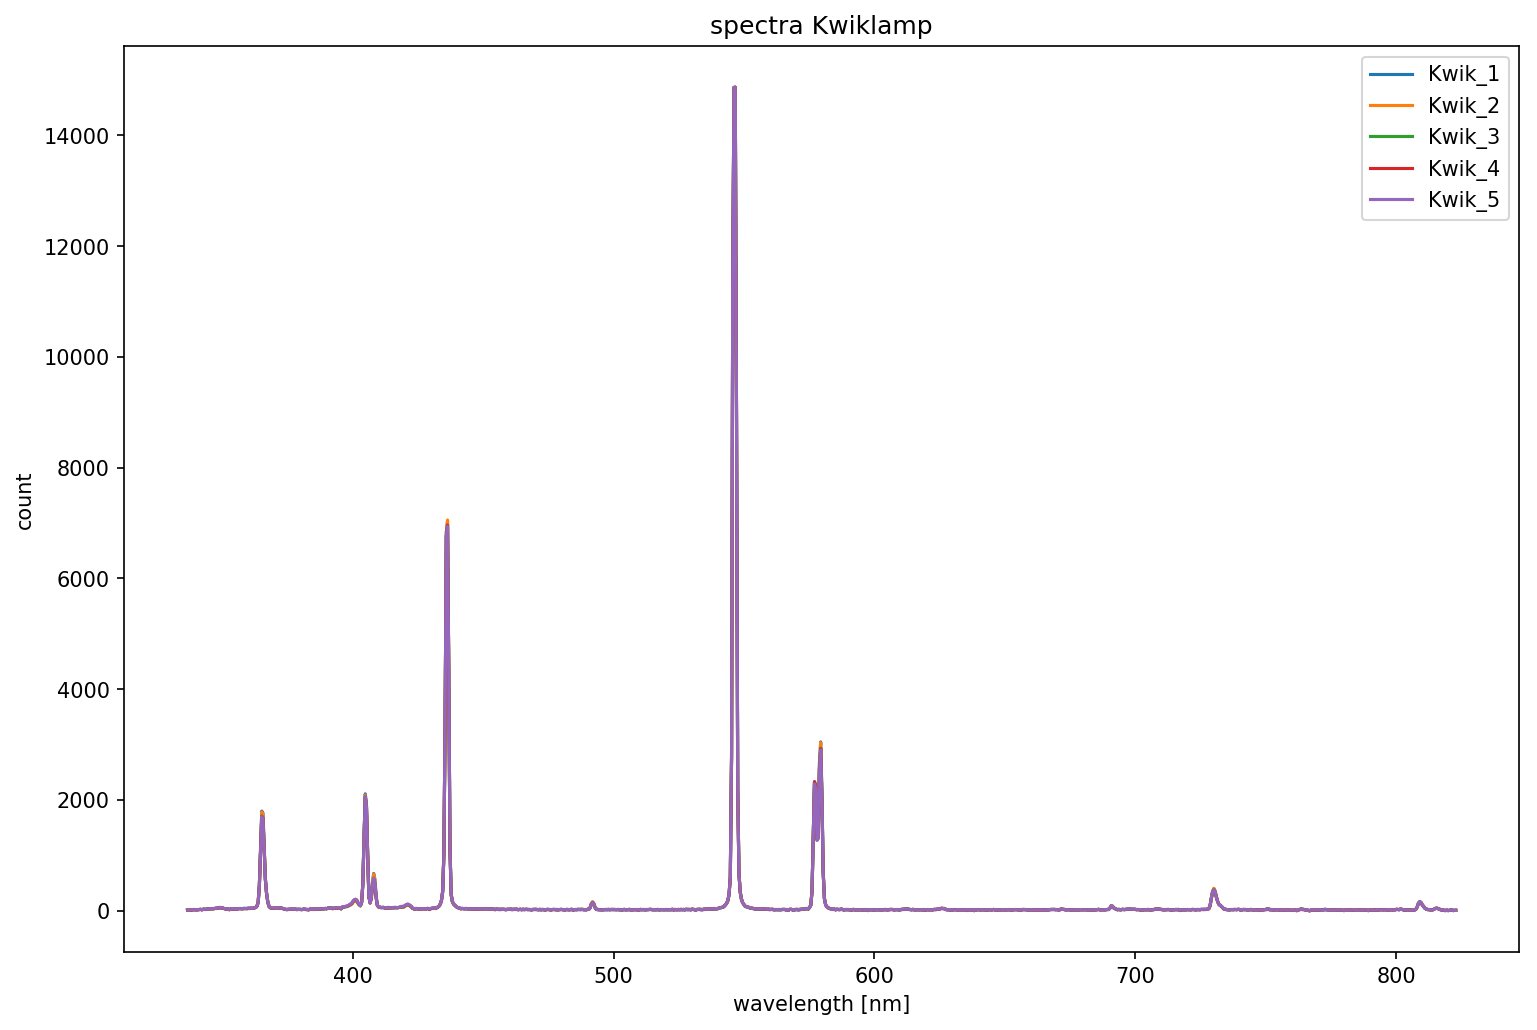

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for i in range(5):
    spectrum = kwik[i]
    ax.plot(spectrum.index, spectrum['intensity'], label="Kwik_%d" %(i+1))
    
plt.title('spectra Kwiklamp')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('count')
plt.legend()
    
plt.show()

Zijn allemaal ongeveer hetzelfde, we werken verder met kwik_1

In [31]:
spec_Hg = kwik[0]

Spectra TL-lamp

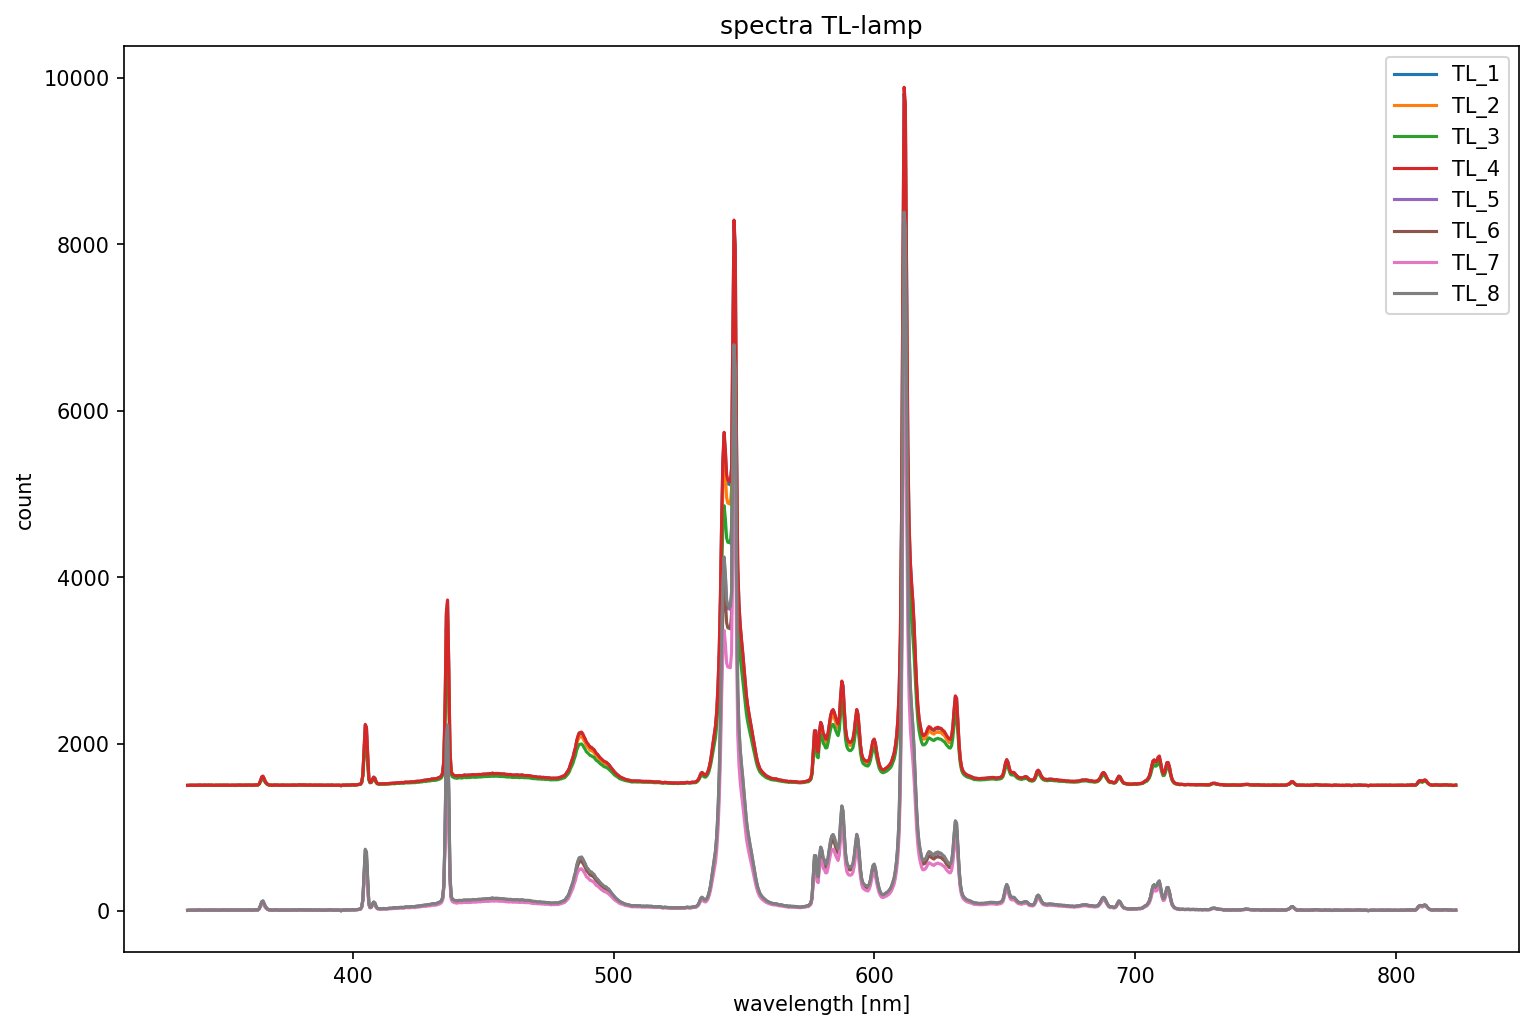

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for i in range(8):
    spectrum = TL[i]
    ax.plot(spectrum.index, spectrum['intensity'], label="TL_%d" %(i+1))
    
plt.title('spectra TL-lamp')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('count')
plt.legend()
    
plt.show()

Neem een spectra met achtergrond weggefilterd, we werken verder met TL_8

In [33]:
spec_TL = TL[7]

### functie om golflengte naar rgb om te zetten

In [34]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return "#%02X%02X%02X" %(int(R*255), int(G*255), int(B*255))

In [35]:
def fill_spectrum(spec, intensity, ax):
    # iterate over every section of the graph
    for i in range(len(spec)-1):
        ax.fill_between(spec[i:i+2], intensity[i:i+2],[0,0],
                        color=wavelength_to_rgb((spec[i]+spec[i+1])/2))
    # do some basic layout
    ax.set_xlabel('wavelength [nm]')

### vergelijken spectrum TL-lamp en onbekende lamp

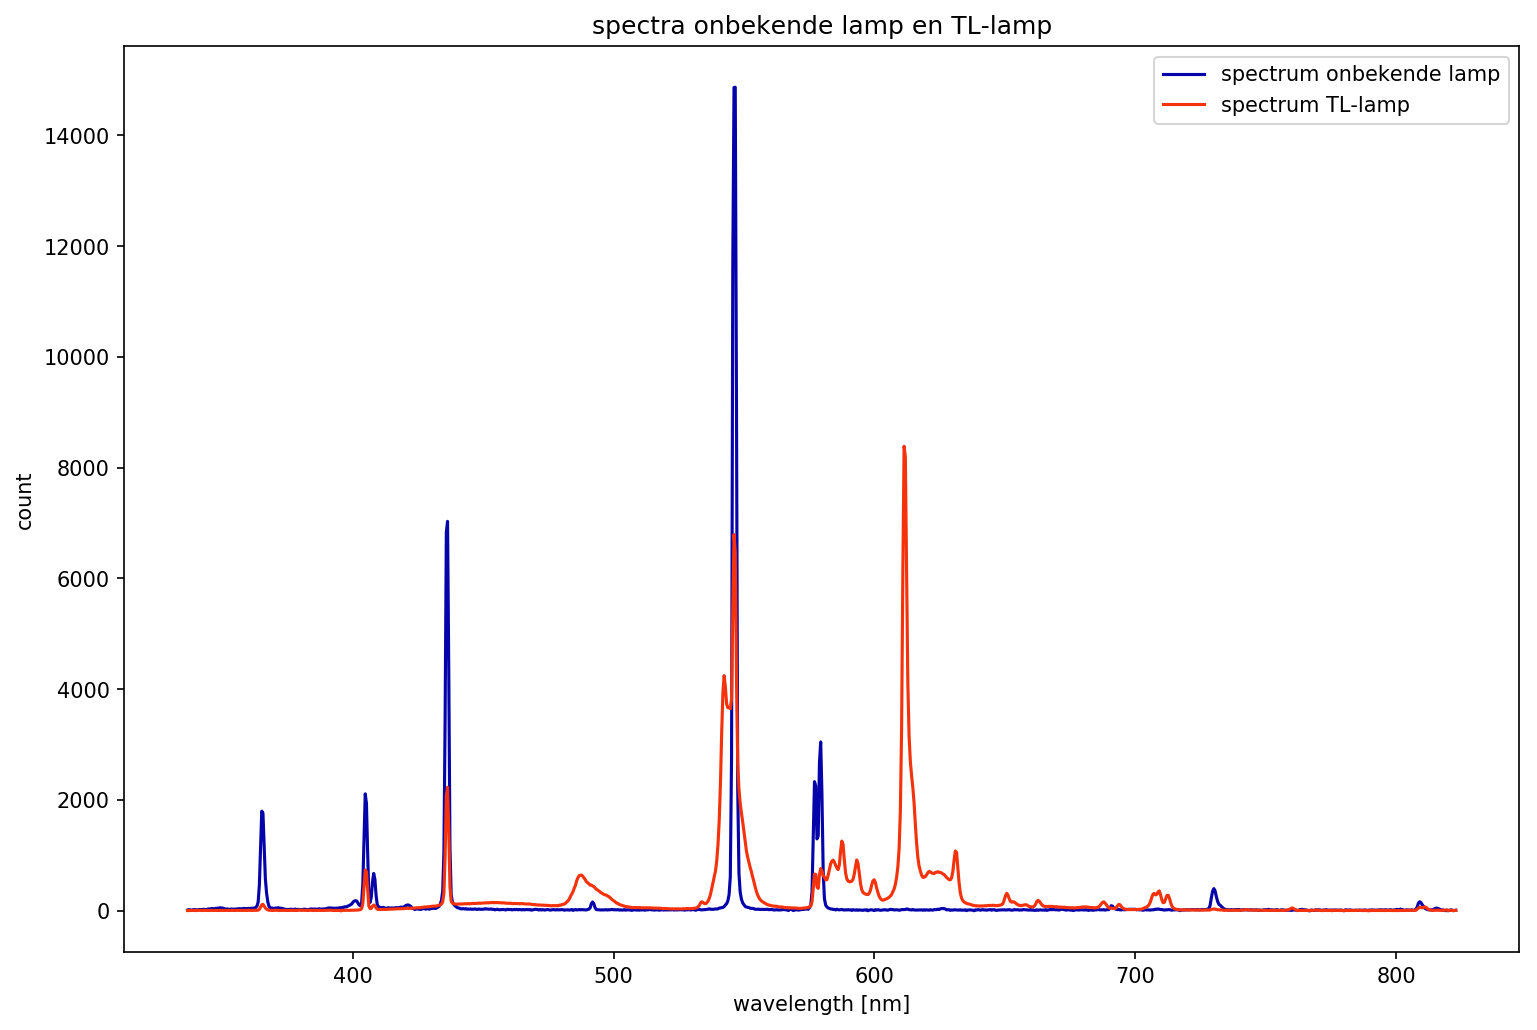

In [36]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(spec_Hg.index, spec_Hg['intensity'], color='xkcd:royal blue', label='spectrum onbekende lamp')
ax.plot(spec_TL.index, spec_TL['intensity'], color='xkcd:vermillion', label='spectrum TL-lamp')

plt.title('spectra onbekende lamp en TL-lamp')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('count')
plt.legend()
    
plt.show()

### Fitten Lorentz profiel door pieken Helium

In [37]:
# definieer de functie om te fitten
def Lorentz(x, x0, gamma, I):
    return I/(2*np.pi)*gamma/((x-x0)**2 + (gamma/2)**2)

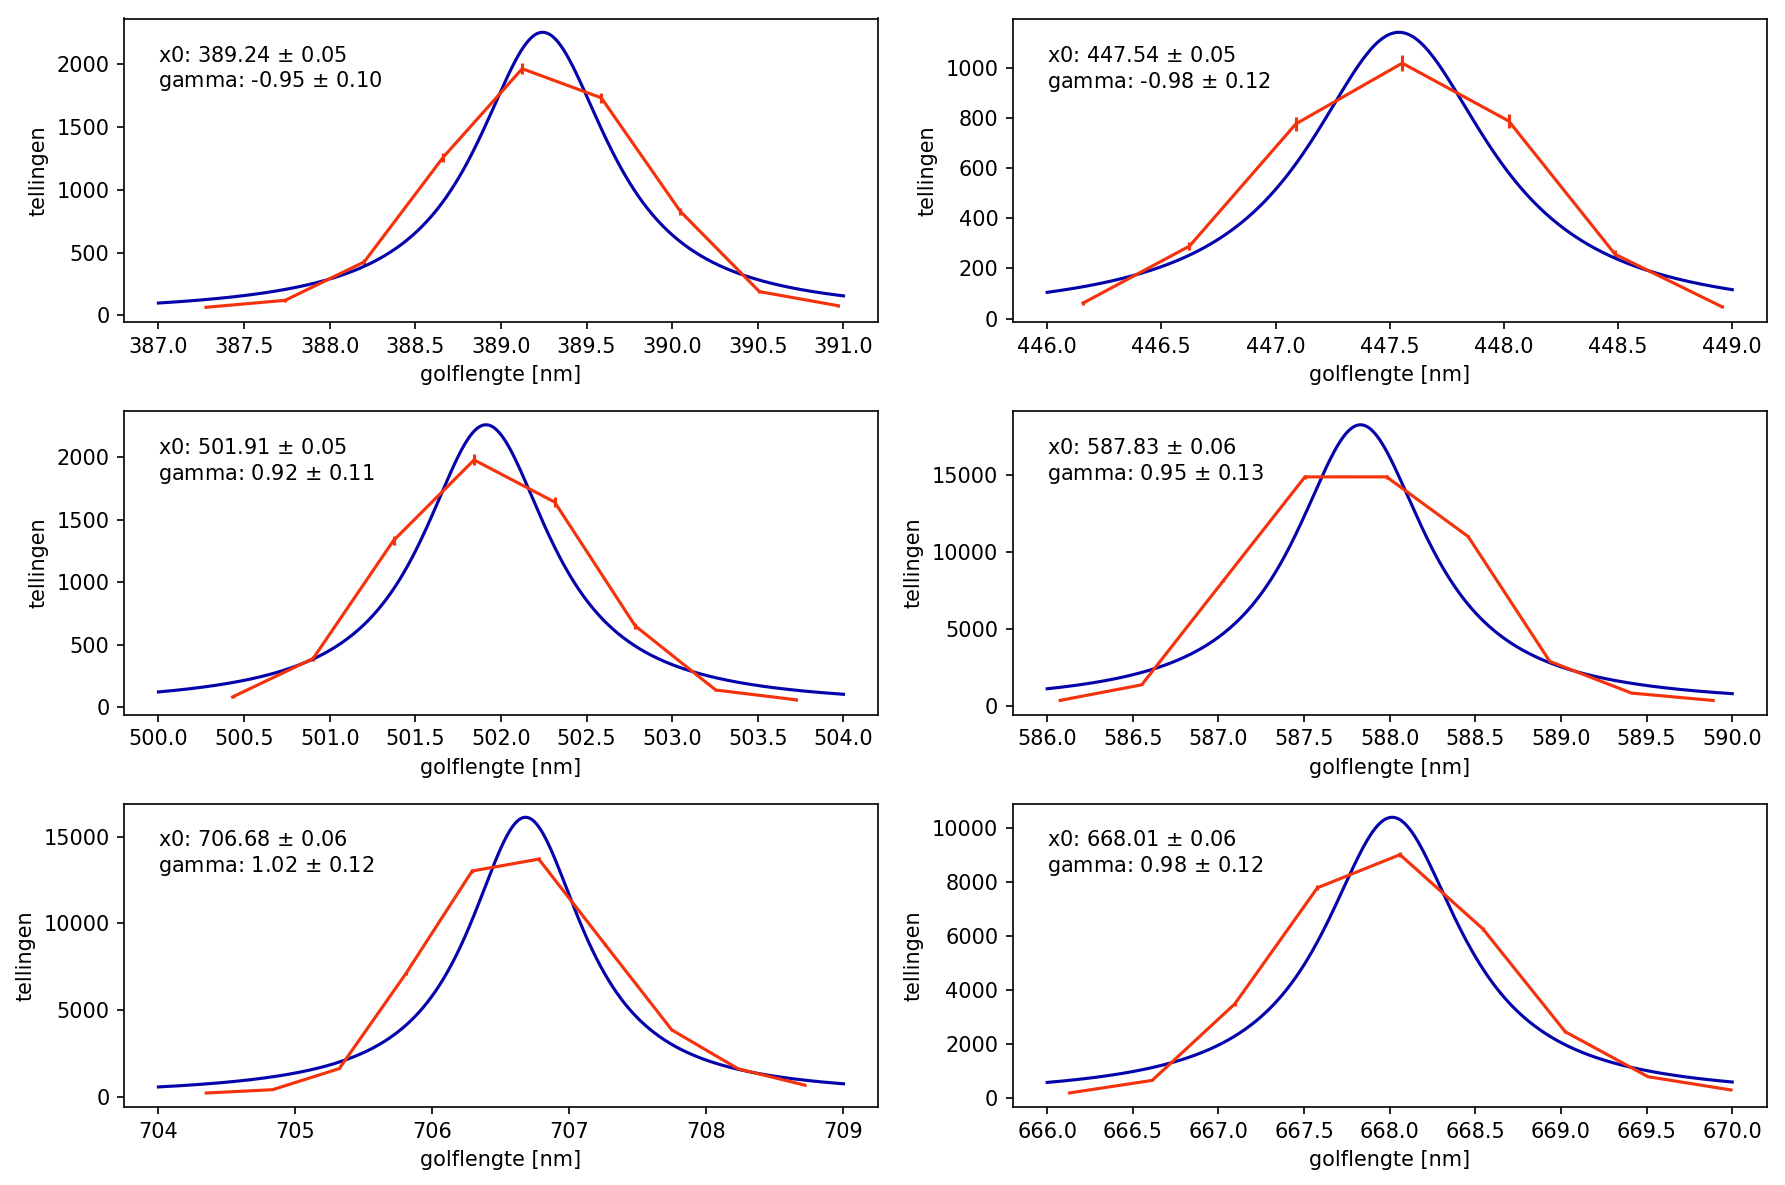

In [38]:
# definieer de bereiken waarop de (enkelvoudige) pieken van het heliumspectrum liggen
ranges = [(387, 391), (446, 449), (500, 504), (586, 590), (704, 709), (666, 670)]
# fit de data en plot de fit

fig, ax = plt.subplots(3,2,figsize=(12,8))

for i in range(6):
    # get the relevant data
    x_min = ranges[i][0]
    x_max = ranges[i][1]
    X = np.linspace(x_min, x_max, 500)
    df = spec_He[x_min:x_max]
    
    # add extra points for better fit
    fit_x = np.copy(df.index.values)
    fit_y = np.copy(df['intensity'].values)
    fit_x = np.concatenate((fit_x, (fit_x[:-1]+fit_x[1:])/2))
    fit_y = np.concatenate((fit_y, (fit_y[:-1]+fit_y[1:])/2))
    fit = opt.curve_fit(Lorentz, fit_x, fit_y, p0=((x_min+x_max)/2, 5, 10_000), sigma=np.sqrt(fit_y))
    Y = Lorentz(X, *fit[0])
    #print(fit)
    ax[i//2, i%2].errorbar(df.index, df['intensity'], np.sqrt(df['intensity']), color='xkcd:vermillion')
    ax[i//2, i%2].plot(X, Y, color='xkcd:royal blue')
    ax[i//2, i%2].text(x_min, np.max(Y)*0.8, "x0: %.2f $\pm$ %.2f\ngamma: %.2f $\pm$ %.2f"
              %(fit[0][0], np.sqrt(fit[1][0,0]), fit[0][1], np.sqrt(fit[1][1,1])))
    ax[i//2, i%2].set_xlabel('golflengte [nm]')
    ax[i//2, i%2].set_ylabel('tellingen')
    
fig.tight_layout()
fig.savefig('plots/Lorentzprofielen Helium.%s' %extensie, dpi=300)

### fitten Lorentz profiel door spectra kwik

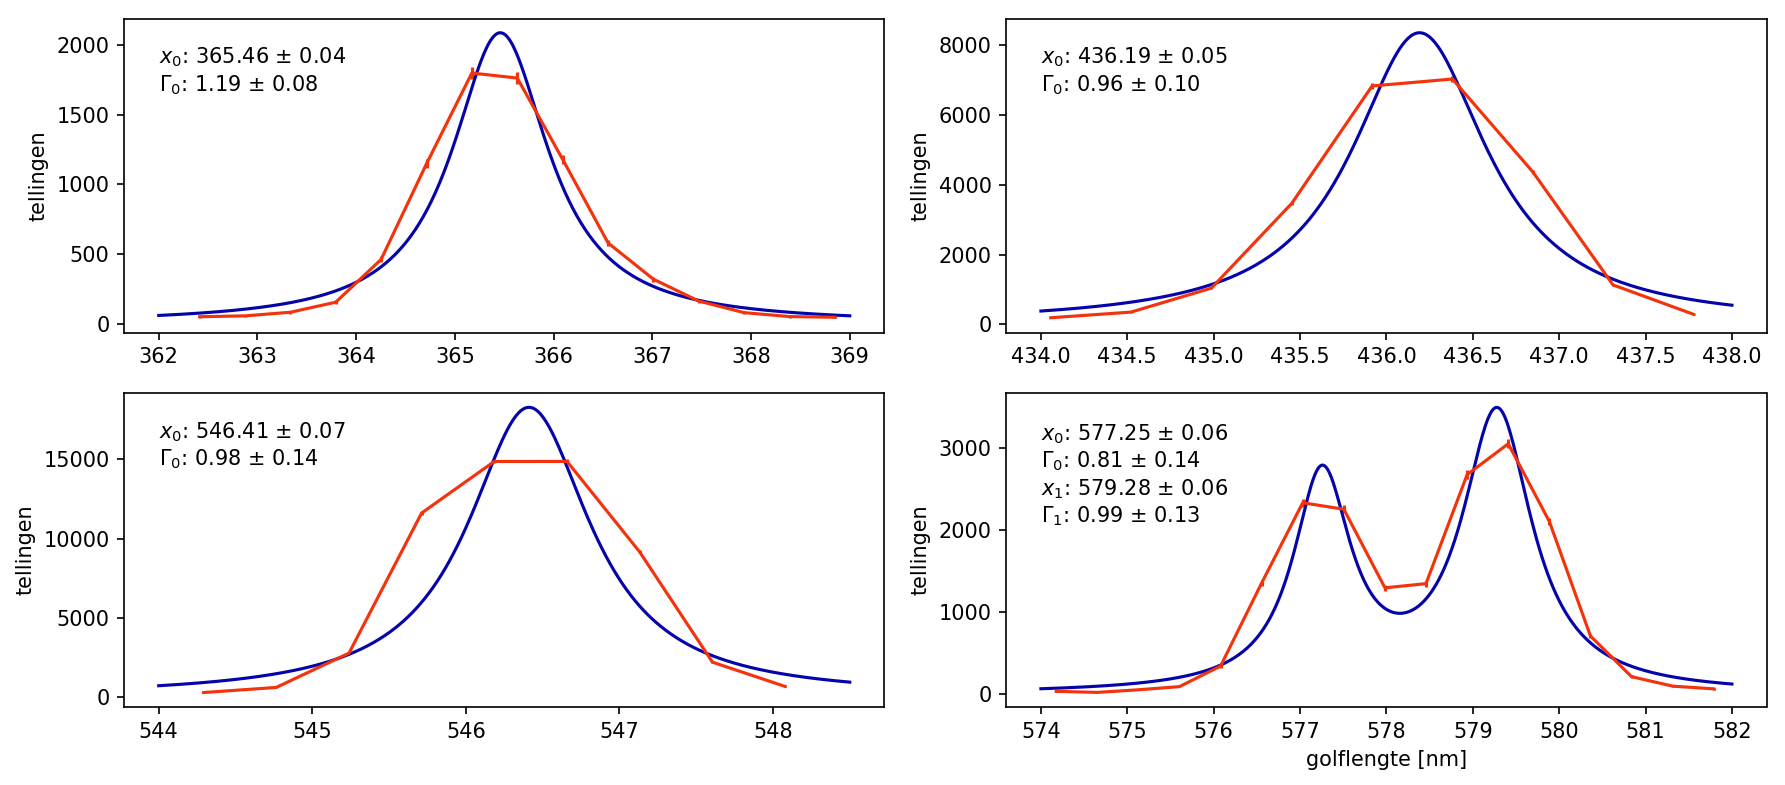

In [39]:
# definieer de bereiken waarop de (enkelvoudige) pieken van het heliumspectrum liggen
ranges = [(362, 369), (434, 438), (544, 548.5)]
# fit de data en plot de fit

fig, ax = plt.subplots(2,2,figsize=(12,8*2/3))

for i in range(3):
    # get the relevant data
    x_min = ranges[i][0]
    x_max = ranges[i][1]
    X = np.linspace(x_min, x_max, 500)
    df = spec_Hg[x_min:x_max]
    
    # add extra points for better fit
    fit_x = np.copy(df.index.values)
    fit_y = np.copy(df['intensity'].values)
    fit_x = np.concatenate((fit_x, (fit_x[:-1]+fit_x[1:])/2))
    fit_y = np.concatenate((fit_y, (fit_y[:-1]+fit_y[1:])/2))
    fit = opt.curve_fit(Lorentz, fit_x, fit_y, p0=((x_min+x_max)/2, 5, 10_000), sigma=np.sqrt(fit_y))
    Y = Lorentz(X, *fit[0])
    # plotten en layout
    ax[i//2, i%2].errorbar(df.index, df['intensity'], np.sqrt(df['intensity']), color='xkcd:vermillion')
    ax[i//2, i%2].plot(X, Y, color='xkcd:royal blue')
    ax[i//2, i%2].text(x_min, np.max(Y)*0.8, "$x_0$: %.2f $\pm$ %.2f\n$\Gamma_0$: %.2f $\pm$ %.2f"
          %(fit[0][0], np.sqrt(fit[1][0,0]), fit[0][1], np.sqrt(fit[1][1,1])))
    ax[i//2, i%2].set_ylabel('tellingen')
    
# fit voor dubbele piek in geel spectrum
def two_lorentz(x, x0, x1, gamma0, gamma1, I0, I1):
    return Lorentz(x, x0, gamma0, I0)+Lorentz(x, x1, gamma1, I1)
x_min = 574
x_max = 582
# fit de functie
df = spec_Hg[x_min:x_max]
fit_x = np.copy(df.index.values)
fit_y = np.copy(df['intensity'].values)
fit_x = np.concatenate((fit_x, (fit_x[:-1]+fit_x[1:])/2))
fit_y = np.concatenate((fit_y, (fit_y[:-1]+fit_y[1:])/2))
fit = opt.curve_fit(two_lorentz, fit_x,  fit_y, sigma=np.sqrt(fit_y),
                   p0=(577, 579.5, 1, 1, 2000, 2000))
X = np.linspace(x_min, x_max, 500)
Y = two_lorentz(X, *fit[0])
ax[1,1].errorbar(df.index, df['intensity'], np.sqrt(df['intensity']), color='xkcd:vermillion')
ax[1,1].plot(X, Y, color='xkcd:royal blue')
ax[1,1].text(x_min, np.max(Y)*0.6, "$x_0$: %.2f $\pm$ %.2f\n$\Gamma_0$: %.2f $\pm$ %.2f\n\
$x_1$: %.2f $\pm$ %.2f\n$\Gamma_1$: %.2f $\pm$ %.2f"
          %(fit[0][0], np.sqrt(fit[1][0,0]), fit[0][2], np.sqrt(fit[1][2,2]),
            fit[0][1], np.sqrt(fit[1][1,1]), fit[0][3], np.sqrt(fit[1][3,3])))
ax[1,1].set_xlabel('golflengte [nm]')
ax[1,1].set_ylabel('tellingen')

fig.tight_layout()
fig.savefig('plots/Lorentzprofielen kwik.%s' %extensie, dpi=300)

### plot 3 spectra onder elkaar

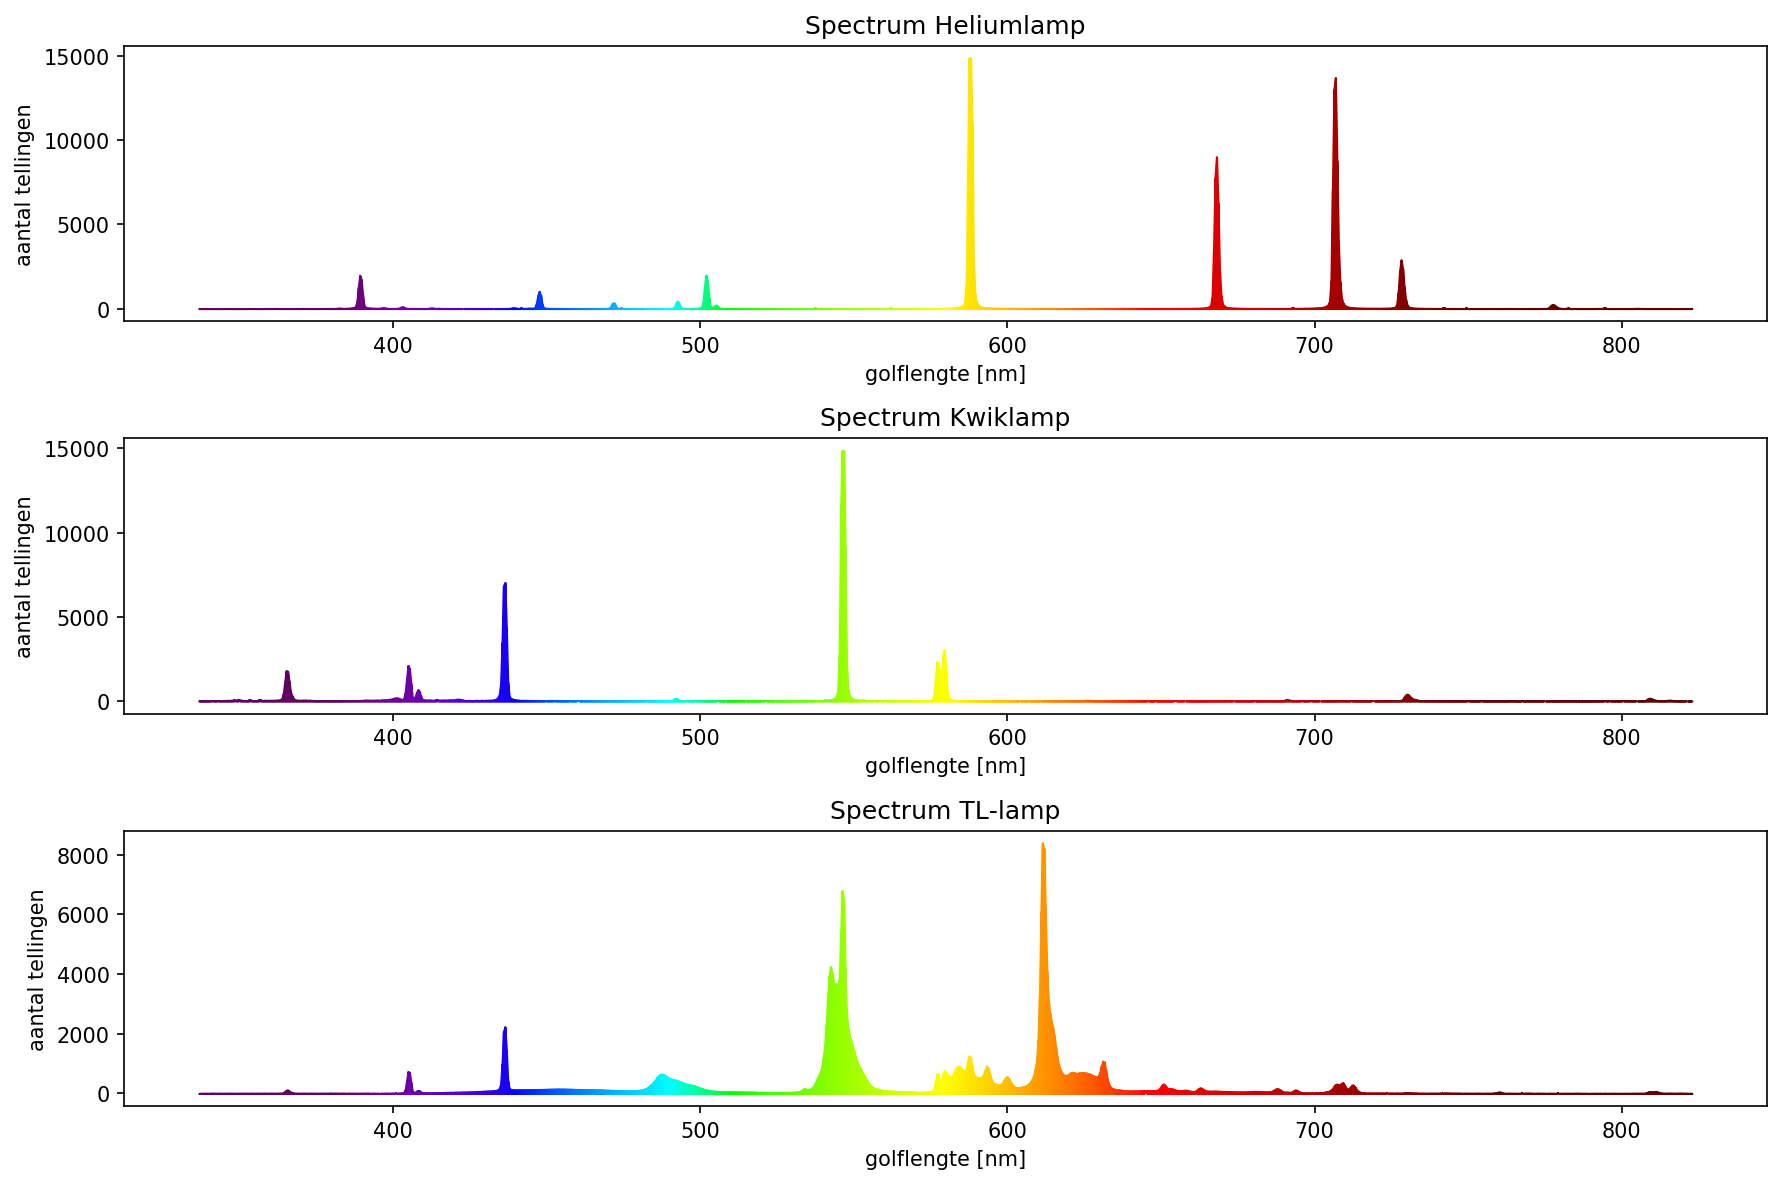

In [40]:
fig, ax = plt.subplots(3,1,figsize=(12,8))

fill_spectrum(spec_He.index.values, spec_He['intensity'].values, ax[0])
ax[0].set_title("Spectrum Heliumlamp")
ax[0].set_xlabel("golflengte [nm]")
ax[0].set_ylabel("aantal tellingen")

fill_spectrum(spec_Hg.index.values, spec_Hg['intensity'].values, ax[1])
ax[1].set_title("Spectrum Kwiklamp")
ax[1].set_xlabel("golflengte [nm]")
ax[1].set_ylabel("aantal tellingen")

fill_spectrum(spec_TL.index.values, spec_TL['intensity'].values, ax[2])
ax[2].set_title("Spectrum TL-lamp")
ax[2].set_xlabel("golflengte [nm]")
ax[2].set_ylabel("aantal tellingen")

fig.tight_layout()
plt.show()

fig.savefig('plots/vergelijken spectra.%s' %extensie, dpi=300)

## Absorptiespectra

### Importeren data absorptiespectra

In [41]:
absorptie_spectra = [pd.read_csv('digitale spectra/Absorbance_%d.txt' %(i+1), skiprows=17, decimal=',', sep='\t', 
                       index_col='wavelength', names=['wavelength', 'Absorbance']) for i in range(15)]

In [42]:
blauw = absorptie_spectra[0:5]
rood = absorptie_spectra[5:10]
geel = absorptie_spectra[10:15]

### Plot de absorptiespectra

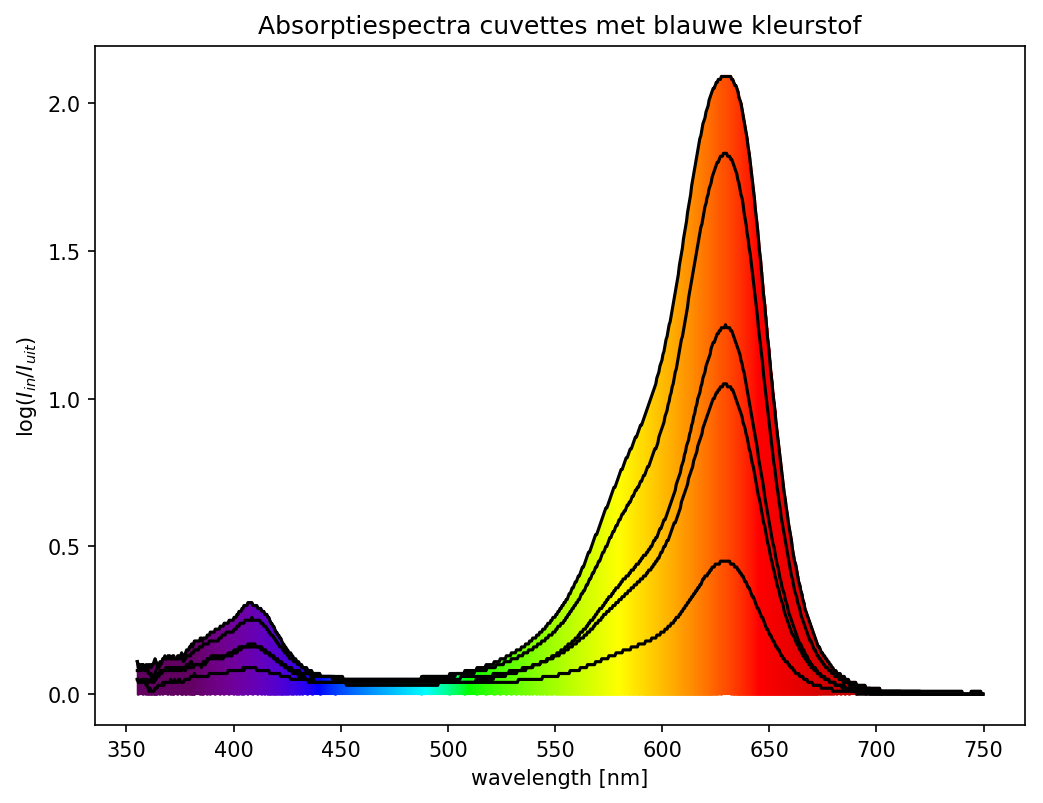

In [43]:
# plots absorptiespectra blauw
fig, ax = plt.subplots(1,1,figsize=(8,6))

# plot het eerste absorptiespectra met opvulling
spec = blauw[0]
X = spec.index.values[40:874]
Y = spec['Absorbance'].values[40:874]
fill_spectrum(X, Y - min(Y), ax)

# plot de andere absorptiecurves als zwarte lijnen over het spectrum
for spec in blauw:
    X = spec.index.values[40:874]
    Y = spec['Absorbance'].values[40:874]
    ax.plot(X, Y - min(Y), color='k')

plt.title('Absorptiespectra cuvettes met blauwe kleurstof')
ax.set_ylabel('log($I_{in}/I_{uit}$)')

plt.show()

fig.savefig('plots/absorptiespectra_blauw.%s' %extensie)

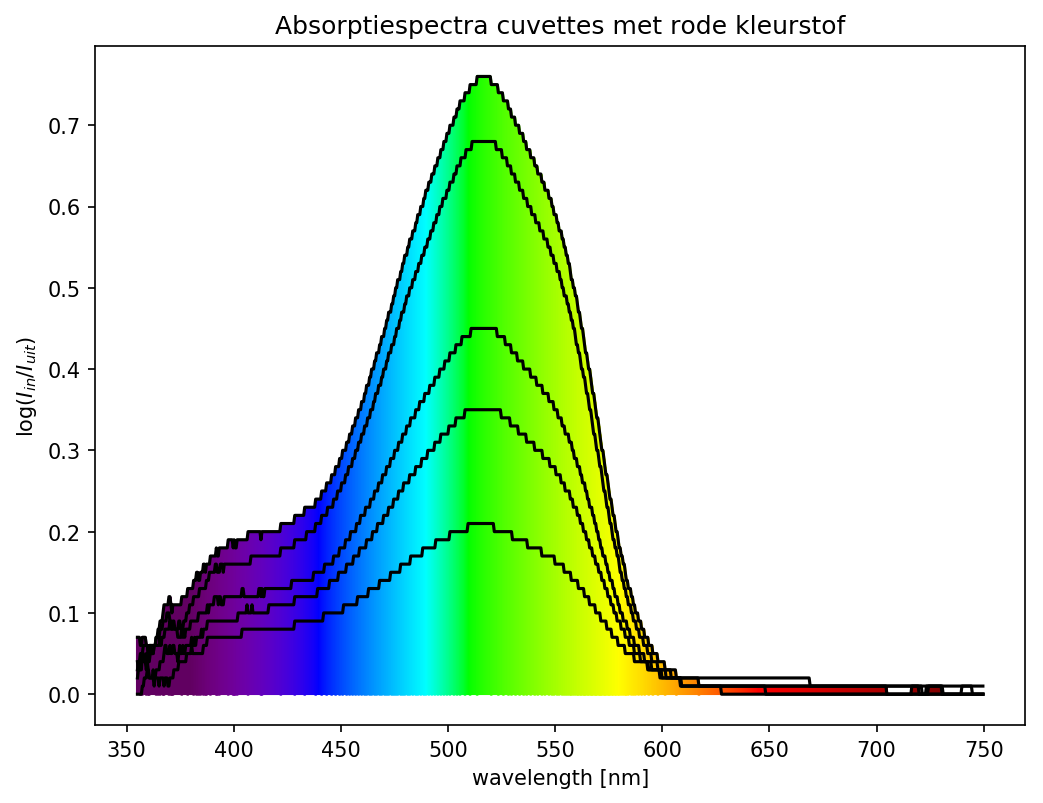

In [44]:
# plots absorptiespectra rood
fig, ax = plt.subplots(1,1,figsize=(8,6))

# plot het eerste absorptiespectra met opvulling
spec = rood[0]
X = spec.index.values[40:874]
Y = spec['Absorbance'].values[40:874]
fill_spectrum(X, Y - min(Y), ax)

# plot de andere absorptiecurves als zwarte lijnen over het spectrum
for spec in rood:
    X = spec.index.values[40:874]
    Y = spec['Absorbance'].values[40:874]
    ax.plot(X, Y - min(Y), color='k')

plt.title('Absorptiespectra cuvettes met rode kleurstof')
ax.set_ylabel('log($I_{in}/I_{uit}$)')

plt.show()

fig.savefig('plots/absorptiespectra_rood.%s' %extensie)

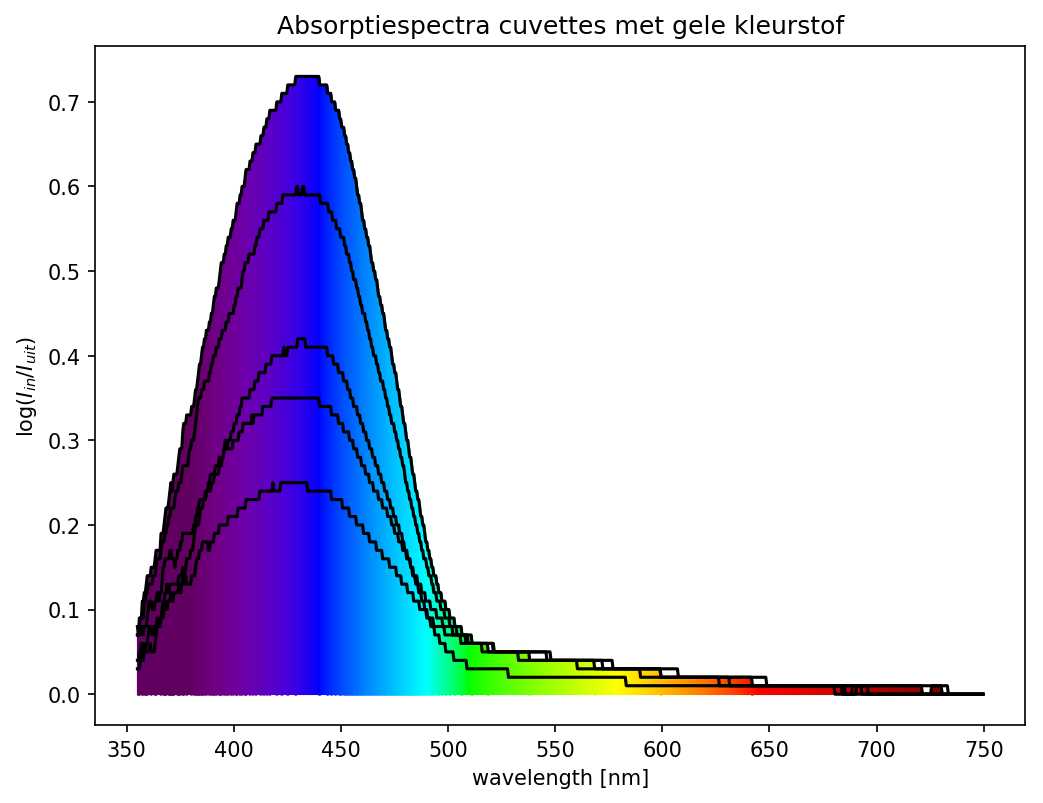

In [45]:
# plots absorptiespectra geel
fig, ax = plt.subplots(1,1,figsize=(8,6))

# plot het eerste absorptiespectra met opvulling
spec = geel[0]
X = spec.index.values[40:874]
Y = spec['Absorbance'].values[40:874]
fill_spectrum(X, Y - min(Y), ax)

# plot de andere absorptiecurves als zwarte lijnen over het spectrum
for spec in geel:
    X = spec.index.values[40:874]
    Y = spec['Absorbance'].values[40:874]
    ax.plot(X, Y - min(Y), color='k')

plt.title('Absorptiespectra cuvettes met gele kleurstof')
ax.set_ylabel('log($I_{in}/I_{uit}$)')

plt.show()

fig.savefig('plots/absorptiespectra_geel.%s' %extensie)

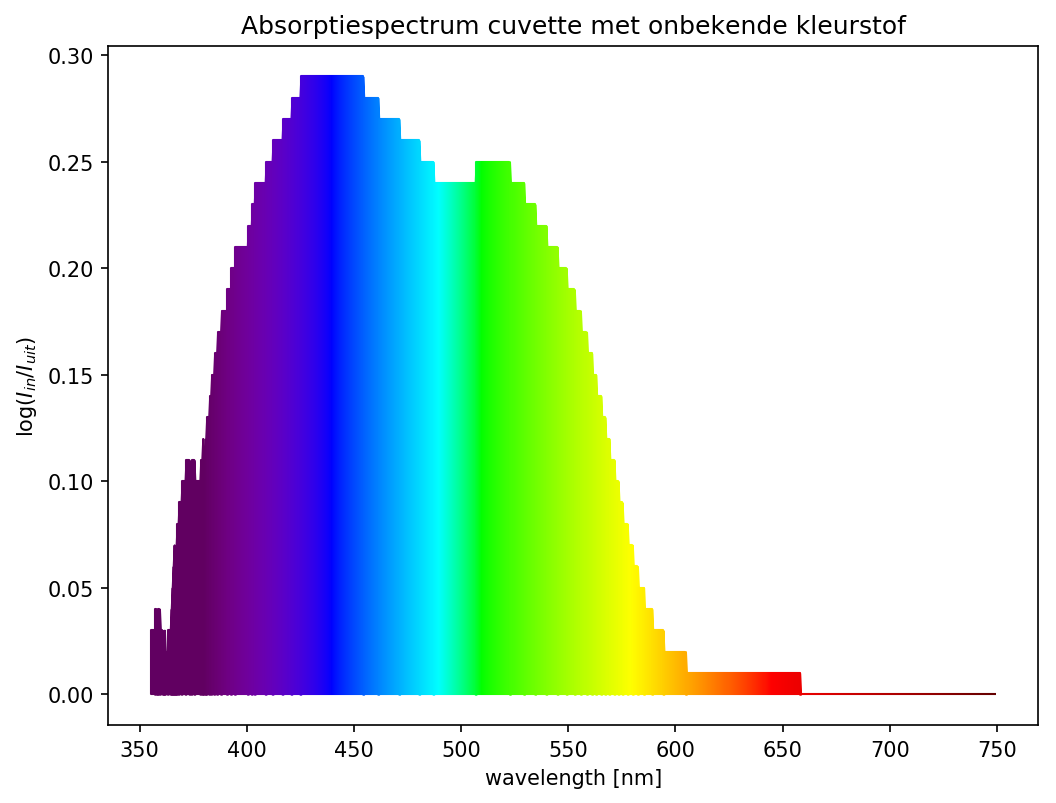

In [46]:
# absorptiespectrum onbekend
mystery = pd.read_csv('digitale spectra/mystery_Absorbance_1.txt', skiprows=17, decimal=',', sep='\t', 
                       index_col='wavelength', names=['wavelength', 'Absorbance'])
spec = mystery

fig, ax = plt.subplots(1,1,figsize=(8,6))

# plot het eerste absorptiespectra met opvulling
X = spec.index.values[40:874]
Y = spec['Absorbance'].values[40:874]
fill_spectrum(X, Y - min(Y), ax)

plt.title('Absorptiespectrum cuvette met onbekende kleurstof')
ax.set_ylabel('log($I_{in}/I_{uit}$)')

plt.show()

fig.savefig('plots/absorptiespectrum_onbekend.%s' %extensie)

### Bepalen concentratie onbekende kleurstof

In [47]:
# bepaal de maximale waardes van absorptie voor elke oplossing
lambda_m_b = np.array([max(spec['Absorbance']) for spec in blauw])
M_b = np.array([7.44e-6, 5.95e-6, 4.46e-6, 2.98e-6, 1.49e-6])
lambda_m_r = np.array([max(spec['Absorbance']) for spec in rood])
M_r = np.array([1.38e-5, 1.1e-5, 8.26e-6, 5.5e-6, 2.75e-6])
lambda_m_g = np.array([max(spec['Absorbance']) for spec in geel])
M_g = np.array([1.13e-5, 9.04e-6, 6.78e-6, 4.52e-6, 2.26e-6])

# de te fitten functie die het verband tussen absorptie en concentratie vastlegt
def absorbance(M, epsilon_l):
    return epsilon_l*M

# de fouten op de gemeten absorpties
errors = np.array([0.02 for _ in range(5)])

# fit de rechtes
fit_b = opt.curve_fit(absorbance, M_b, lambda_m_b, p0=(5e6), sigma=errors)
fit_r = opt.curve_fit(absorbance, M_r, lambda_m_r, p0=(5e6), sigma=errors)
fit_g = opt.curve_fit(absorbance, M_g, lambda_m_g, p0=(5e6), sigma=errors)

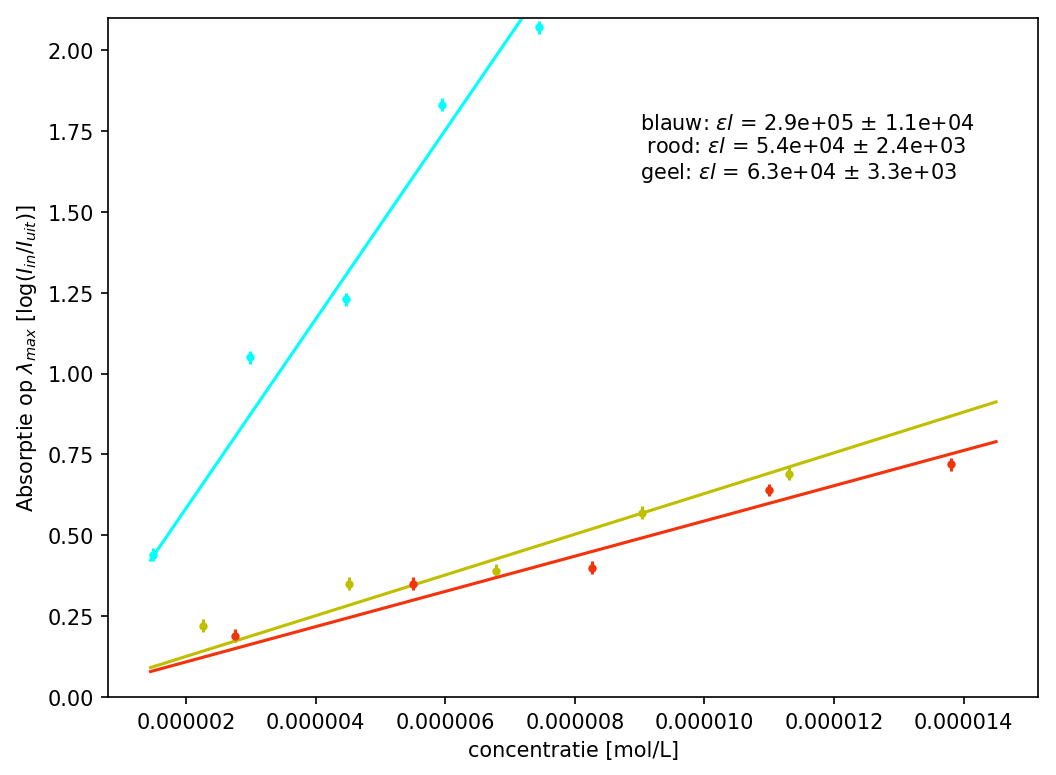

In [48]:
# plot de fits (op 1 plot?)
fig, ax = plt.subplots(1,1,figsize=(8,6))

# plot de datapunten
ax.errorbar(M_b, lambda_m_b, errors, fmt='.', color='xkcd:cyan')
ax.errorbar(M_r, lambda_m_r, errors, fmt='.', color='xkcd:vermillion')
ax.errorbar(M_g, lambda_m_g, errors, fmt='.', color='y')

# plot de fits
X = np.linspace(1.45e-6, 1.45e-5, 100)
ax.plot(X, absorbance(X, *fit_b[0]), color='xkcd:cyan')
ax.plot(X, absorbance(X, *fit_r[0]), color='xkcd:vermillion')
ax.plot(X, absorbance(X, *fit_g[0]), color='y')

ax.set_xlabel('concentratie [mol/L]')
ax.set_ylabel('Absorptie op $\lambda_{max}$ [$\log(I_{in}/I_{uit})$]')
ax.set_ylim(0, 2.1)

ax.text(0.000009, 1.6, "blauw: $\epsilon l$ = %.1e $\pm$ %.1e\n rood: $\epsilon l$ = %.1e $\pm$ %.1e\n\
geel: $\epsilon l$ = %.1e $\pm$ %.1e" %(fit_b[0][0], np.sqrt(fit_b[1][0,0]), 
        fit_r[0][0], np.sqrt(fit_r[1][0,0]), fit_g[0][0], np.sqrt(fit_g[1][0,0])))

plt.show()

fig.savefig('plots/fits absorptie.%s' %extensie)

### bepalen onbekende concentraties

In [49]:
# bepaal de uitdrukkingen om de concentratie en fout hierop uit te rekenen
A, el, M, S_A, S_el = sp.symbols('A, el, M, S_A, S_el')
lambert_beer = sp.Eq(A, el*M)
M = sp.solve(lambert_beer, M)[0]
S_M = error(M, [A, el], [S_A, S_el])

In [50]:
# bepaal de maximale waardes in het absorptiespectrum van de onbekende stof
max_geel = max(mystery[400:500]['Absorbance'])
max_rood = max(mystery[500:600]['Absorbance'])
# bereken de concentraties en fouten hierop
M_num = sp.lambdify([A, el], M, "numpy")(np.array([max_geel, max_rood]), np.array([fit_g[0][0], fit_r[0][0]]))
S_M_num = sp.lambdify([A, el, S_A, S_el], S_M, "numpy")(np.array([max_geel, max_rood]), 
    np.array([fit_g[0][0], fit_r[0][0]]), np.array([0.02, 0.02]), np.array([fit_g[1][0,0], fit_r[1][0,0]]))
print('concentratie gele kleurstof: %.2e +- %.0e\n' %(M_num[0], S_M_num[0]))
print('concentratie rode kleurstof: %.2e +- %.0e\n' %(M_num[1], S_M_num[1]))

concentratie gele kleurstof: 4.13e-06 +- 7e-04

concentratie rode kleurstof: 4.04e-06 +- 4e-04

